In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import isfile, join
import pymc3 as pm
import math as m
import arviz as az

import dive
import matplotlib.pyplot as plt
import deerlab as dl

from theano import tensor as T
from theano.tensor import nlinalg as tnp
from theano.tensor import slinalg as snp

### Generate a synthetic distribution and calculate S

In [2]:
data, pars = dive.generateMultiGauss(nt = 160, seed = 129, k = 0.5, sigma = 0.01, V0 = 1.15, t_edges=[-0.1,3.0])

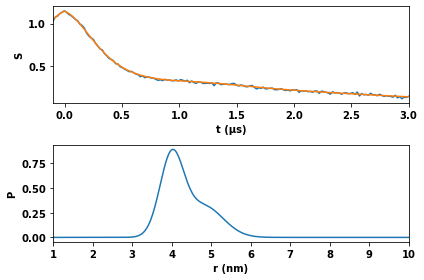

In [3]:
t = data['t']
Vexp = data['V']

fig, ax = plt.subplots(2,1)
line0 = ax[0].plot(t, Vexp)
line1 = ax[0].plot(t, data['V0'])
line2 = ax[1].plot(data['r'], data['P'])

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'S')
ax[1].set(xlim = [min(data['r']),max(data['r'])], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

### Initialize parameters and matrices

-0.322206410488911


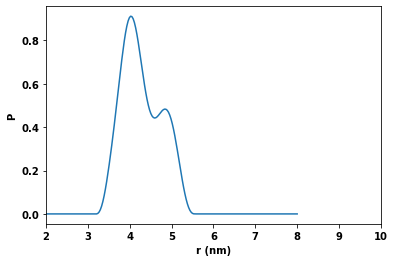

In [5]:
# r vector
r = np.linspace(2,8,200)
dr = r[1] - r[0]

fit = dl.fitmodel(Vexp,t,r,'P',dl.bg_exp,dl.ex_4pdeer)
plt.plot(r,fit.P)
plt.xlabel('r (nm)')
plt.ylabel('P')
plt.yticks()
plt.xlim([2,10])
print(np.log10(fit.regparam))

# kernel regularization operator
K0 = dl.dipolarkernel(t,r,integralop=False)   # kernel matrix
L = dl.regoperator(np.linspace(1,len(r),len(r)), 2)
LtL = np.matmul(np.transpose(L),L)
K0tK0 = np.matmul(np.transpose(K0),K0)

# parameters for delta distribution
a0 = 0.01
b0 = 1e-6

### Generate the FULL model graph (not used in actual computation)

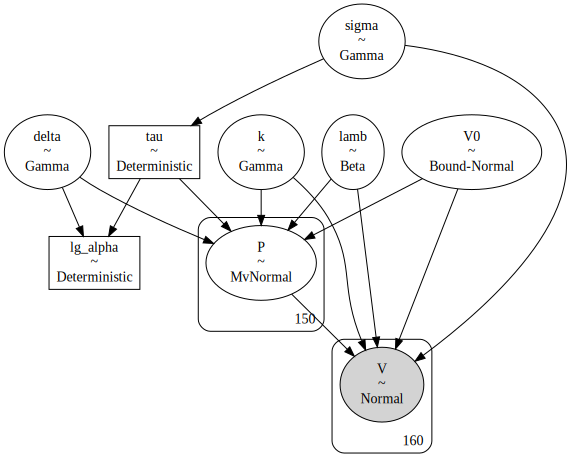

In [12]:
with pm.Model() as FullModel:
    # Noise --------------------------------------------------------------
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    tau = pm.Deterministic('tau',1/(sigma**2))

    # Regularization parameter -------------------------------------------
    delta = pm.Gamma('delta', alpha=a0, beta=b0, transform = None)
    lg_alpha = pm.Deterministic('lg_alpha', np.log10(np.sqrt(delta/tau)) )
    
    # Time Domain --------------------------------------------------------
    lamb = pm.Beta('lamb', alpha=1.3, beta=2.0)
    V0 = pm.Bound(pm.Normal, lower=0.0)('V0', mu=1, sigma=0.2)

    # Background ---------------------------------------------------------
    k = pm.Gamma('k', alpha=0.5, beta=2)
    B = dl.bg_exp(t, k)

    # Calculate matrices and operators -----------------------------------
    Kintra = (1-lamb) + lamb*K0
    B_ = T.transpose( T.tile(B,(len(r),1)) )
    K = V0*Kintra*B_*dr

    # Distance distribution ----------------------------------------------
    KtK = T.tensordot(T.transpose(K),K)
    invSigma = (tau*KtK+delta*LtL)
    Sigma = tnp.matrix_inverse(invSigma)
    C_L = snp.cholesky(Sigma)
    P = pm.MvNormal("P", mu = fit.P, chol = C_L, shape = len(r), transform = None)    

    # Time domain model ---------------------------------------------------
    Vmodel = pm.math.dot(K,P)

    # Likelihood ----------------------------------------------------------
    pm.Normal('V',mu = Vmodel, sigma = sigma, observed = Vexp)

pm.model_to_graphviz(FullModel) 

### Setup model

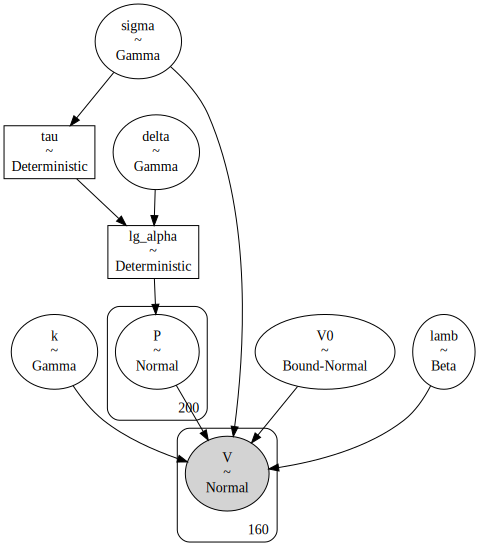

In [6]:
with pm.Model() as model:
    # Noise --------------------------------------------------------------
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    tau = pm.Deterministic('tau',1/(sigma**2))

    # Regularization parameter -------------------------------------------
    delta = pm.Gamma('delta', alpha=a0, beta=b0, transform = None)
    lg_alpha = pm.Deterministic('lg_alpha', np.log10(np.sqrt(delta/tau)) )
    
    # Time Domain --------------------------------------------------------
    lamb = pm.Beta('lamb', alpha=1.3, beta=2.0)
    V0 = pm.Bound(pm.Normal, lower=0.0)('V0', mu=1, sigma=0.2)

    # Background ---------------------------------------------------------
    k = pm.Gamma('k', alpha=0.5, beta=2)
    B = dl.bg_exp(t, k)

    # Distance distribution ----------------------------------------------
    P = pm.Normal("P", mu = 1, sigma = lg_alpha, shape = len(r), transform = None)      

    # Calculate matrices and operators -----------------------------------
    Kintra = (1-lamb) + lamb*K0
    B_ = T.transpose( T.tile(B,(len(r),1)) )
    K = V0*Kintra*B_*dr

    # Time domain model ---------------------------------------------------
    Vmodel = pm.math.dot(K,P)

    # Likelihood ----------------------------------------------------------
    pm.Normal('V',mu = Vmodel, sigma = sigma, observed = Vexp)

pm.model_to_graphviz(model) 

### Run sampler

In [7]:
with model:
    step_P = dive.SamplePfromV(P, K0, LtL, t, Vexp, r, delta, sigma, k, lamb, V0)
    step_delta = dive.randDelta(delta, a0, b0, L, P)
    trace = pm.sample(step = [step_P, step_delta], chains=4, cores=4, draws=10000, tune= 1000, return_inferencedata=False, progressbar = False, init ='adapt_diag')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>SamplePfromV: [P]
>randDelta: [delta]
>NUTS: [k, V0, lamb, sigma]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 2707 seconds.
The acceptance probability does not match the target. It is 0.9584661314503302, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5510 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.15435727211397504, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9388555996165232, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4465 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It 

### Analysis

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k,0.205,0.151,0.000,0.447,0.052,0.038,11.0,37.0,1.29
λ,0.739,0.103,0.548,0.867,0.037,0.027,9.0,24.0,1.35
V₀,1.145,0.010,1.126,1.161,0.002,0.002,22.0,74.0,1.13
σ,0.020,0.006,0.011,0.030,0.000,0.000,110.0,404.0,1.08
δ,76974.954,56268.502,5548.413,172811.563,5295.671,3754.322,106.0,291.0,1.04
lg(α),0.676,0.097,0.516,0.892,0.020,0.015,39.0,34.0,1.15


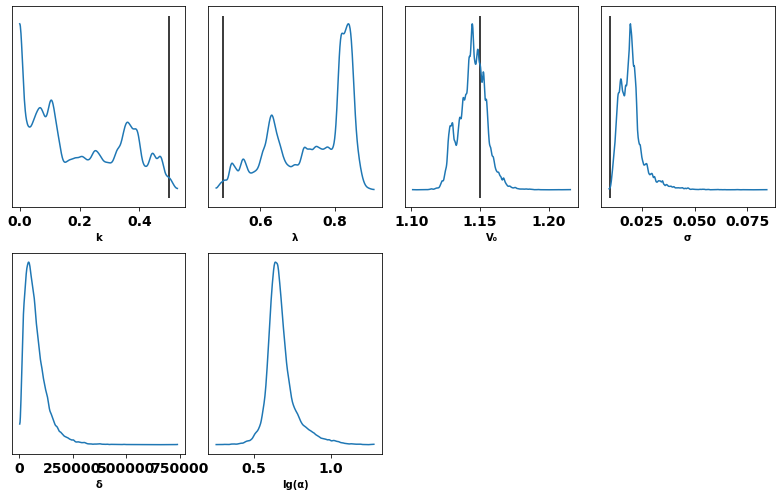

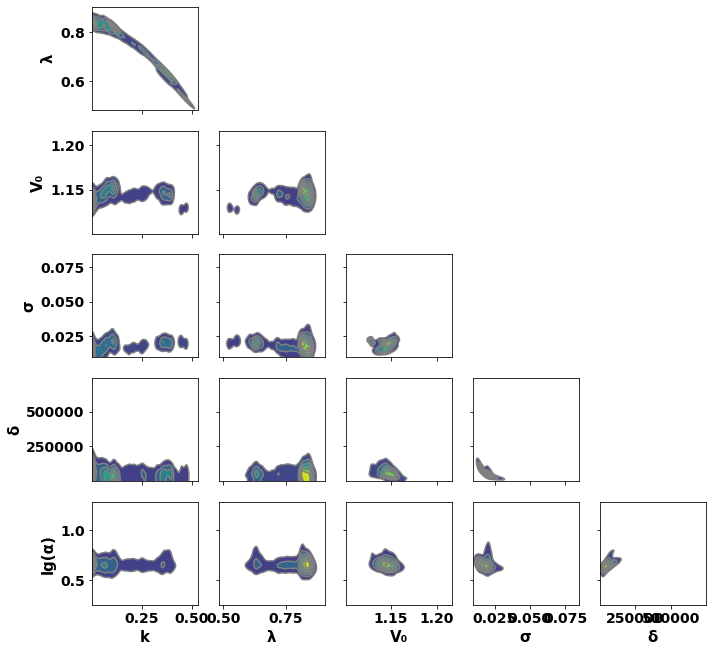

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


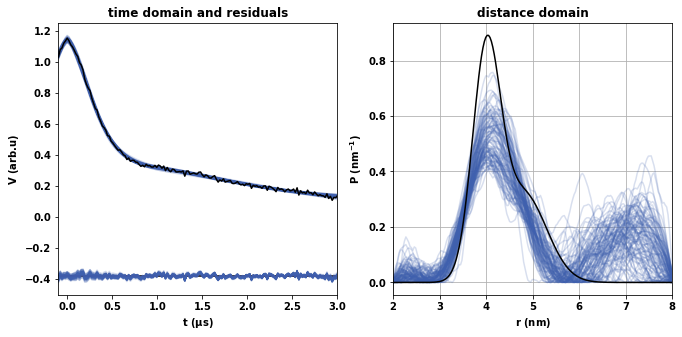

In [9]:
Ptrue = dl.dd_gauss2(r,pars['gaussians'])
dive.summary_legacy(trace, model, Vexp, t, r, Pref = Ptrue, GroundTruth = pars)  